In [16]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from statsmodels.tsa.api import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing

from statsmodels.tsa.api import ARIMA
from statsmodels.tsa.api import adfuller

from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

In [17]:
df = pd.read_csv('C:\\Users\\m9032\\jupyter\\data\\ghana_gdp.csv', parse_dates=['year'], index_col=['year'])

##  <span style="color:red; font-size:24px;">●</span>  Первичный осмотр данных

In [18]:
df.head()

,GDP (current US$)
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 62 entries, 1960-01-01 to 2021-01-01
Data columns (total 1 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   GDP (current US$)  62 non-null     float64
dtypes: float64(1)
memory usage: 992.0 bytes


<span style="font-size:16px;">Данные уже подготовлены 

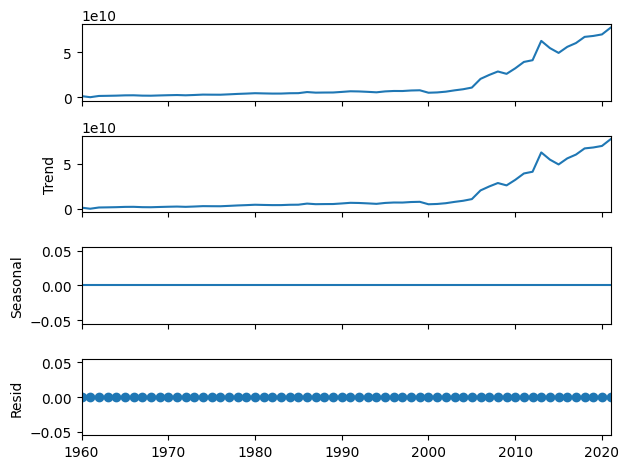

In [20]:
#Посмотрим на декомпозицию временного ряда
seas_dec = seasonal_decompose(df)
seas_dec.plot()
plt.show()

<span style="font-size:16px;"> Виден явный тренд и отсутствие сезонности 

## <span style="color:red; font-size:24px;">●</span> Mean average

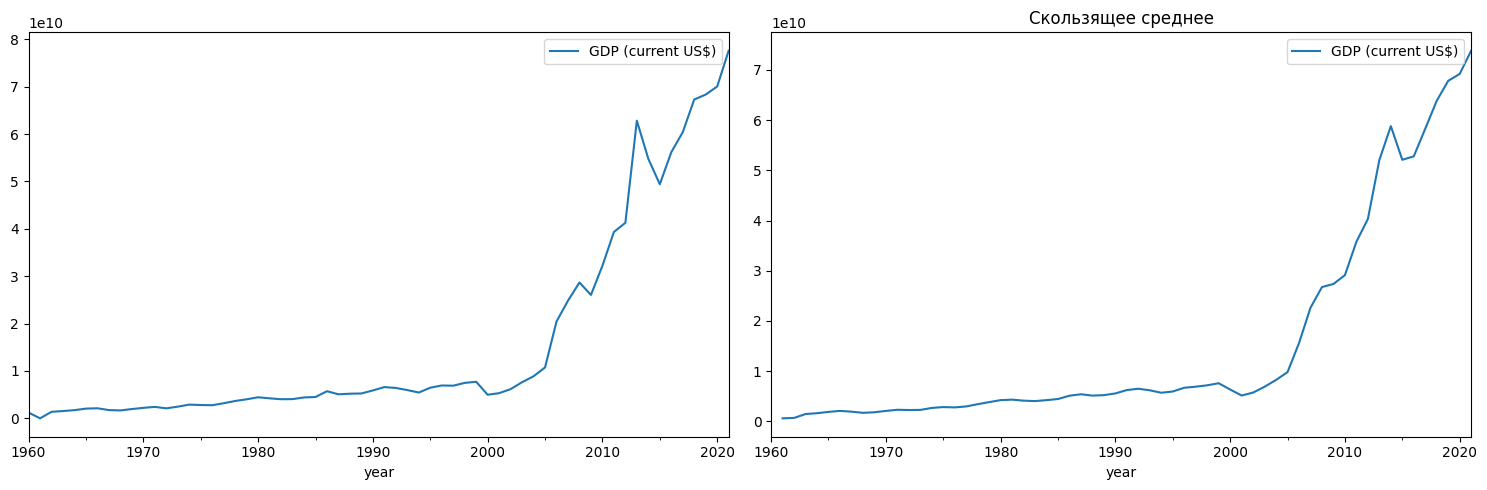

In [21]:
#Построим MA и подберем подходящий 

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
#исходные данные
df.plot(ax=ax[0])

# Второй график: скользящее среднее
df.rolling(2).mean().plot(ax=ax[1])
ax[1].set_title("Скользящее среднее")

plt.tight_layout() 
plt.show()


<span style="font-size:16px;">Построим прогноз используя только MA

In [22]:
train = df.iloc[:-3]
test = df.iloc[-3:]

In [23]:
#Сделвем три прогноза для разных MA

# Период скользящего среднего
MA = 2
train_ma = train.rolling(window=MA).mean()

# Прогноз на 3 года вперед: используем последнее значение скользящего среднего
last_ma_value = train_ma.iloc[-1].values[0]
forecas_ma_2 = pd.date_range(start=train.index[-1] + pd.DateOffset(years=1), periods=3, freq='YE')
forecast_values = [last_ma_value] * 3  # Прогнозируем значение для следующих 3 лет
forecast2 = pd.Series(forecast_values, index=forecas_ma_2)

# Период скользящего среднего
MA = 3
train_ma = train.rolling(window=MA).mean()

# Прогноз на 3 года вперед: используем последнее значение скользящего среднего
last_ma_value = train_ma.iloc[-1].values[0]
forecas_ma_3 = pd.date_range(start=train.index[-1] + pd.DateOffset(years=1), periods=3, freq='YE')
forecast_values = [last_ma_value] * 3  # Прогнозируем значение для следующих 3 лет
forecast3 = pd.Series(forecast_values, index=forecas_ma_3)

# Период скользящего среднего
MA = 4
train_ma = train.rolling(window=MA).mean()

# Прогноз на 3 года вперед: используем последнее значение скользящего среднего
last_ma_value = train_ma.iloc[-1].values[0]
forecas_ma_4 = pd.date_range(start=train.index[-1] + pd.DateOffset(years=1), periods=3, freq='YE')
forecast_values = [last_ma_value] * 3  # Прогнозируем значение для следующих 3 лет
forecast4 = pd.Series(forecast_values, index=forecas_ma_4)


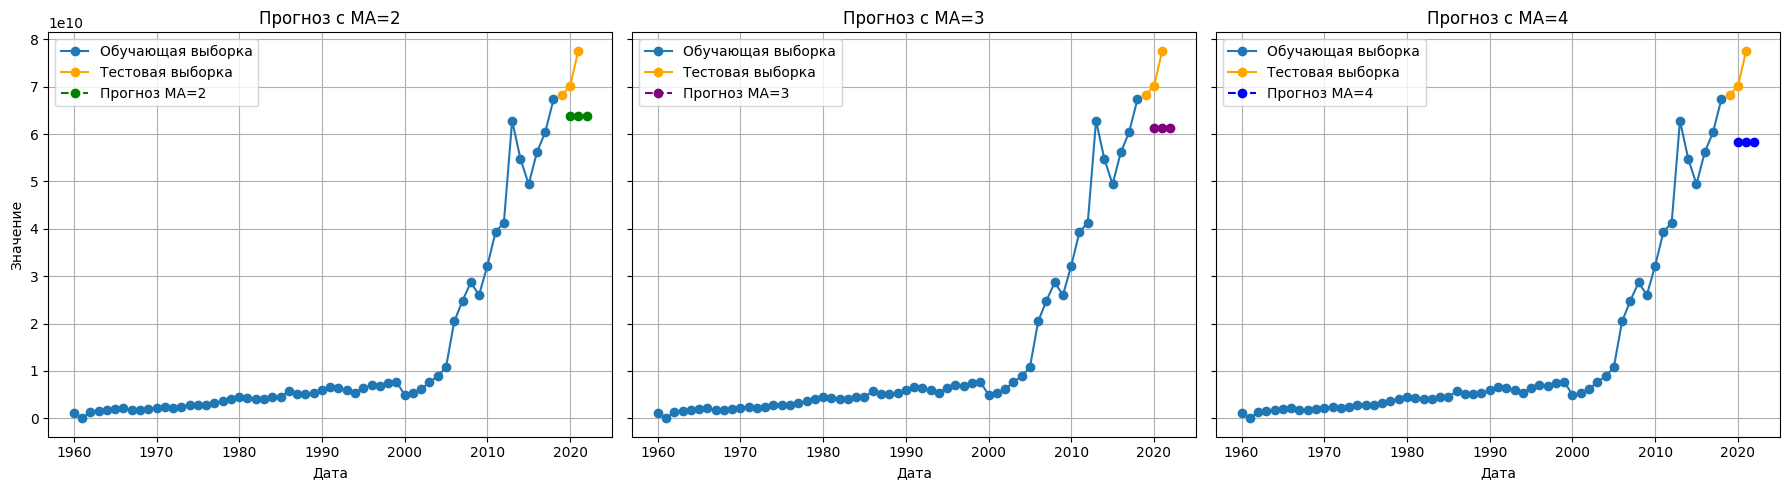

In [24]:
#Визуализация

fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

# График с прогнозом MA=2
axs[0].plot(train, label='Обучающая выборка', marker='o')
axs[0].plot(test, label='Тестовая выборка', marker='o', color='orange')
axs[0].plot(forecast2, label='Прогноз MA=2', linestyle='--', marker='o', color='green')
axs[0].set_title("Прогноз с MA=2")
axs[0].set_xlabel("Дата")
axs[0].set_ylabel("Значение")
axs[0].legend()
axs[0].grid(True)

# График с прогнозом MA=3
axs[1].plot(train, label='Обучающая выборка', marker='o')
axs[1].plot(test, label='Тестовая выборка', marker='o', color='orange')
axs[1].plot(forecast3, label='Прогноз MA=3', linestyle='--', marker='o', color='purple')
axs[1].set_title("Прогноз с MA=3")
axs[1].set_xlabel("Дата")
axs[1].legend()
axs[1].grid(True)

# График с прогнозом MA=4
axs[2].plot(train, label='Обучающая выборка', marker='o')
axs[2].plot(test, label='Тестовая выборка', marker='o', color='orange')
axs[2].plot(forecast4, label='Прогноз MA=4', linestyle='--', marker='o', color='blue')
axs[2].set_title("Прогноз с MA=4")
axs[2].set_xlabel("Дата")
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()

<span style="font-size:16px;"> Одинаково бессмысленные прогнозы. <br> Поробуем экспоненциальное сглаживание.

## <span style="color:red; font-size:24px;">●</span> Exponential Smoothing

In [25]:
data = df.copy()
data.index = data.index.to_period('Y').to_timestamp()
train = data.iloc[:-3]
test = data.iloc[-3:]

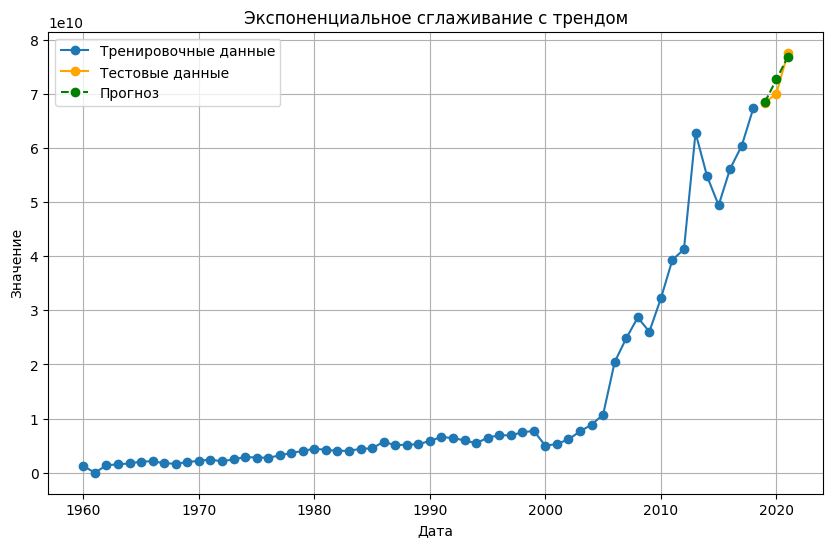

In [26]:
# Модель с учетом тренда
model = ExponentialSmoothing(train, trend='add').fit(
    smoothing_level=0.57, smoothing_trend=0.67, optimized=False
)

forecast_exp = model.forecast(steps=3)

# Визуализация
plt.figure(figsize=(10, 6))
plt.plot(train, label='Тренировочные данные', marker='o')
plt.plot(test, label='Тестовые данные', marker='o', color='orange')
plt.plot(forecast_exp, label='Прогноз', linestyle='--', marker='o', color='green')

plt.title("Экспоненциальное сглаживание с трендом")
plt.xlabel("Дата")
plt.ylabel("Значение")
plt.legend()
plt.grid(True)
plt.show()

In [27]:
print(f' RMSE {root_mean_squared_error(test, forecast_exp):.0f}')
print(f' MAPE - {mean_absolute_percentage_error(test, forecast_exp)*100:.3f}%')

 RMSE 1561162233
 MAPE - 1.591%


<span style="font-size:16px;"> Уже намного лучше, однако похоже на переобучение. <br> Теперб поробую ARIMA 

## <span style="color:red; font-size:24px;">●</span> ARIMA

### Проанализируем данные, для нахождения p, d, q

In [28]:
# Функция для поиска порядка d, для стационарности ряда
def stat(df, n):
    for i in range(n):
        df = df.diff()
        
    df = df.dropna()
    # Тест adfuller
    result = adfuller(df)
    if result[0] > result[4]['1%']: 
        print ('есть единичные корни, ряд не стационарен')
    else:
        print ('единичных корней нет, ряд стационарен')
    return result[0],  result[4]

In [29]:
stat(df, 2), stat(df, 3)

есть единичные корни, ряд не стационарен
единичных корней нет, ряд стационарен


((-1.745908762849135,
  {'1%': -3.5714715250448363,
   '5%': -2.922629480573571,
   '10%': -2.5993358475635153}),
 (-5.278476343687468,
  {'1%': -3.5714715250448363,
   '5%': -2.922629480573571,
   '10%': -2.5993358475635153}))

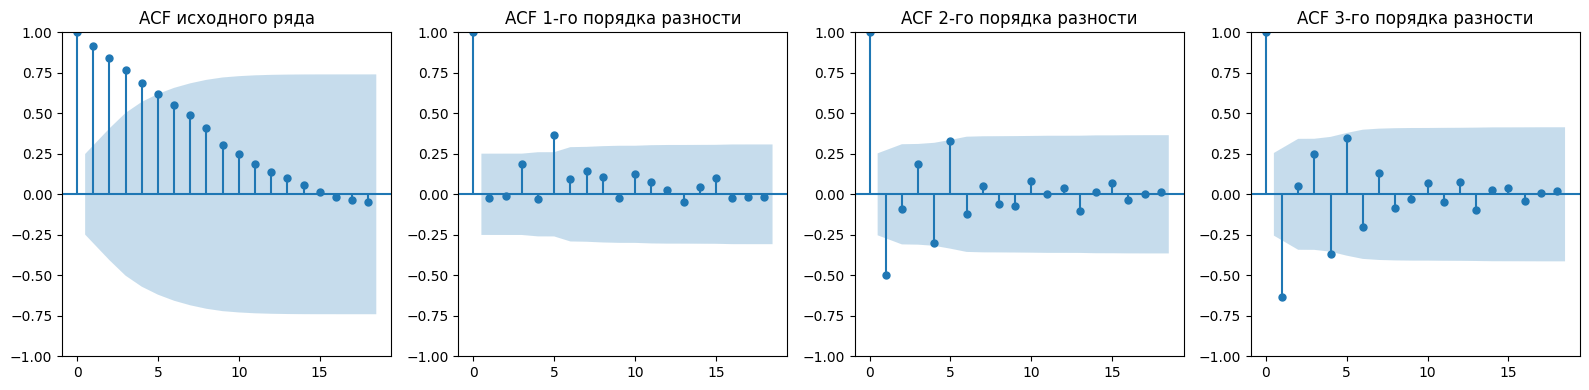

In [30]:
fig, ax = plt.subplots(1, 4, figsize=(16, 4))  

# Построение автокорреляционной функции (ACF) для оригинальных и дифференцированных данных
plot_acf(df, ax=ax[0])
ax[0].set_title('ACF исходного ряда')

plot_acf(df.diff().dropna(), ax=ax[1])
ax[1].set_title('ACF 1-го порядка разности')

plot_acf(df.diff().diff().dropna(), ax=ax[2])
ax[2].set_title('ACF 2-го порядка разности')

plot_acf(df.diff().diff().diff().dropna(), ax=ax[3])
ax[3].set_title('ACF 3-го порядка разности')

plt.tight_layout()
plt.show()

<span style="font-size:16px;"> По тесту Дики-Фуллера ряд стационарен при d = 3 и на соответствующем графике, есть два пика - 1 и 4, но график 1 и 2 тоже похожи на стационарные.

In [31]:
# Приведем данные к стационарному виду по тесту
data3 = df.diff().diff().diff().dropna()
# Приведем данные к стационарному виду по графику 
data1 = df.diff().dropna()
data2 = df.diff().diff().dropna()

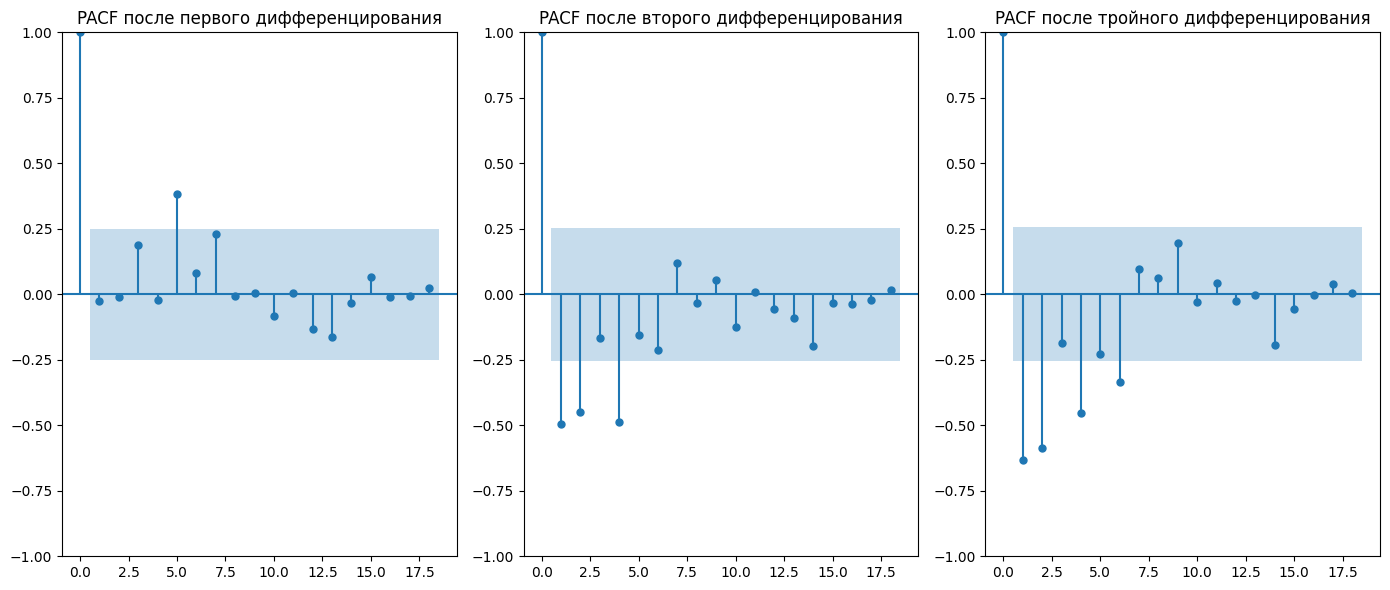

In [32]:
# Визуализация двух PACF-графиков для разных степеней стационарности
fig, axs = plt.subplots(1, 3, figsize=(14, 6))

# График PACF для данных с однократным дифференцированием
plot_pacf(data1, ax=axs[0])
axs[0].set_title("PACF после первого дифференцирования")

# График PACF для данных с однократным дифференцированием
plot_pacf(data2, ax=axs[1])
axs[1].set_title("PACF после второго дифференцирования")

# График PACF для данных с тройным дифференцированием
plot_pacf(data3, ax=axs[2])
axs[2].set_title("PACF после тройного дифференцирования")

plt.tight_layout()
plt.show()

<span style="font-size:16px;"> Поробуем взять d=3, p = 6, q = 1

In [33]:
data = df.copy()
data.index = data.index.to_period('Y').to_timestamp()
train = data.iloc[:-3]
test = data.iloc[-3:]

In [34]:
# модель arima (order=(6, 3, 1))
arima_m = ARIMA(train, order=(6, 3, 1)).fit()


# Строим прогноз на длину тестовой выборки (3 года)
forecast = arima_m.forecast(steps=len(test))

# Создаем серию для прогноза, чтобы она имела те же индексы, что и тестовая выборка
forecast_index = test.index  # Индексы прогноза совпадают с индексами тестовой выборки
forecast_df = pd.Series(forecast, index=forecast_index)

# модель arima (order=(3, 2, 1))
arima_m2 = ARIMA(train, order=(3, 2, 1)).fit()
forecast2 = arima_m2.forecast(steps=len(test))  
forecast2_df = pd.Series(forecast2, index=forecast_index)



c:\Users\m9032\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\m9032\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\m9032\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


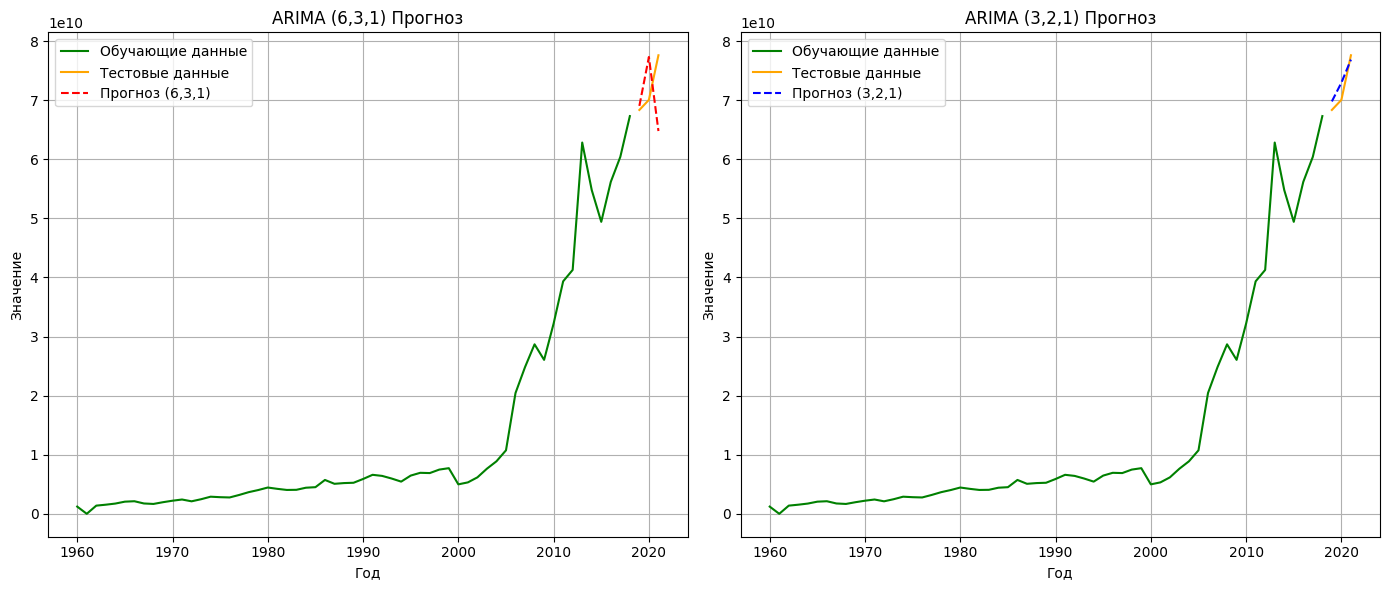

In [35]:
# Создадим два графика рядом для визуализации прогнозов обеих моделей

plt.figure(figsize=(14, 6))

# График для модели arima_m (order=(6, 3, 1))
plt.subplot(1, 2, 1)
plt.plot(train.index, train, label='Обучающие данные', color='green')
plt.plot(test.index, test, label='Тестовые данные', color='orange')
plt.plot(forecast_df.index, forecast_df, label='Прогноз (6,3,1)', color='red', linestyle='--')
plt.title('ARIMA (6,3,1) Прогноз')
plt.xlabel('Год')
plt.ylabel('Значение')
plt.legend()
plt.grid(True)

# График для модели arima_m2 (order=(3, 2, 1))
plt.subplot(1, 2, 2)
plt.plot(train.index, train, label='Обучающие данные', color='green')
plt.plot(test.index, test, label='Тестовые данные', color='orange')
plt.plot(forecast2_df.index, forecast2_df, label='Прогноз (3,2,1)', color='blue', linestyle='--')
plt.title('ARIMA (3,2,1) Прогноз')
plt.xlabel('Год')
plt.ylabel('Значение')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [36]:
print(f' RMSE для первой модели - {root_mean_squared_error(test, forecast_df):.0f}')
print(f' MAPE для первой модели - {mean_absolute_percentage_error(test, forecast_df)*100:.3f}%')
print(f"BIC первой модели: {arima_m.bic:.0f}, HQIC первой модели:{arima_m.hqic:.0f},  aic первой модели: {arima_m.aic:.0f}\n")
print('---' * 15 + '\n')
print(f' RMSE для второй модели - {root_mean_squared_error(test, forecast2_df):.0f}')
print(f' MAPE для второй модели - {mean_absolute_percentage_error(test, forecast2_df)*100:.3f}%')
print(f"BIC второй модели: {arima_m2.bic:.0f}, HQIC второй модели:{arima_m2.hqic:.0f}, aic второй модели: {arima_m2.aic:.0f}")
print('---' * 15 + '\n')

 RMSE для первой модели - 8516797960
 MAPE для первой модели - 9.299%
BIC первой модели: 2645, HQIC первой модели:2635,  aic первой модели: 2629

---------------------------------------------

 RMSE для второй модели - 1923301153
 MAPE для второй модели - 2.407%
BIC второй модели: 2696, HQIC второй модели:2690, aic второй модели: 2686
---------------------------------------------



<span style="font-size:16px;"> Вторая модель с параметрами (3, 2, 1) показывает значительно лучший результат, однако хуже bic, aic и HQIC.  
Стоит продолжить перебор, но уже автоматичсеки. 

In [37]:
# !pip install pmdarima

In [38]:
from pmdarima import auto_arima

In [39]:
# Модель с автоподбором
auto_ar = auto_arima(train, start_p=0, start_q=0, 
                     max_p=6, max_q=6, max_d=4,
                     seasonal=False, suppress_warnings=True, information_criterion='aic')

In [40]:
# Модель с автоподбором и d=3
auto_ar_d = auto_arima(train,d=3, start_p=0, start_q=0, 
                     max_p=6, max_q=6,
                     seasonal=False, suppress_warnings=True, information_criterion='aic')

In [41]:
# Прогноз с доверительным интервалом 95% для первой
forecas_auto_m1, conf_int_1 = auto_ar.predict(n_periods=len(test), return_conf_int=True, alpha=0.05)
forecast_auto_m1_df = pd.Series(forecas_auto_m1, index=forecast_index)

# Создаем серии для нижней и верхней границы доверительного интервала
lower_series = pd.Series(conf_int_1[:, 0], index=forecast_index)
upper_series = pd.Series(conf_int_1[:, 1], index=forecast_index)

# Прогноз с доверительным интервалом 95% для второй
forecas_auto_m2, conf_int_2 = auto_ar_d.predict(n_periods=len(test), return_conf_int=True, alpha=0.05)
forecast_auto_m2_df = pd.Series(forecas_auto_m2, index=forecast_index)

lower_series_2 = pd.Series(conf_int_2[:, 0], index=forecast_index)
upper_series_2 = pd.Series(conf_int_2[:, 1], index=forecast_index)

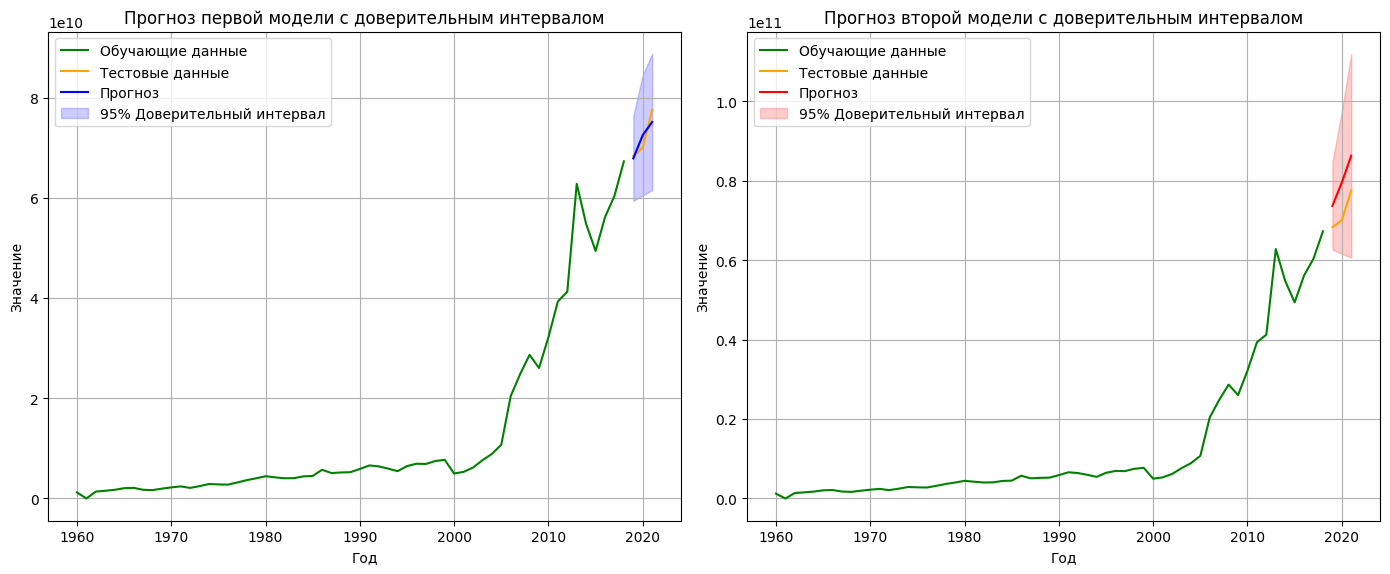

In [42]:
# Создадим графики рядом для визуализации прогнозов с доверительными интервалами

fig, axs = plt.subplots(1, 2, figsize=(14, 6))  

# Первый график — прогноз первой модели с доверительным интервалом
axs[0].plot(train.index, train, label='Обучающие данные', color='green')
axs[0].plot(test.index, test, label='Тестовые данные', color='orange')
axs[0].plot(forecast_auto_m1_df.index, forecast_auto_m1_df, label='Прогноз', color='blue')
axs[0].fill_between(forecast_index, lower_series, upper_series, color='blue', alpha=0.2, label='95% Доверительный интервал')
axs[0].set_title('Прогноз первой модели с доверительным интервалом')
axs[0].set_xlabel('Год')
axs[0].set_ylabel('Значение')
axs[0].legend()
axs[0].grid(True)

# Второй график — прогноз второй модели с доверительным интервалом
axs[1].plot(train.index, train, label='Обучающие данные', color='green')
axs[1].plot(test.index, test, label='Тестовые данные', color='orange')
axs[1].plot(forecast_auto_m2_df.index, forecast_auto_m2_df, label='Прогноз', color='red')
axs[1].fill_between(forecast_index, lower_series_2,upper_series_2, color='red', alpha=0.2, label='95% Доверительный интервал')
axs[1].set_title('Прогноз второй модели с доверительным интервалом')
axs[1].set_xlabel('Год')
axs[1].set_ylabel('Значение')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

In [43]:
# Получение выбранных параметров модели ARIMA
print(f"Выбранные параметры первой модели ARIMA: (p, d, q) = {auto_ar.order}\n")
print(f"Выбранные параметры второй модели ARIMA: (p, d, q) = {auto_ar_d.order}")

Выбранные параметры первой модели ARIMA: (p, d, q) = (1, 2, 3)

Выбранные параметры второй модели ARIMA: (p, d, q) = (2, 3, 1)


In [44]:
print(f' RMSE для первой модели - {root_mean_squared_error(test, forecast_auto_m1_df):.0f}')
print(f' MAPE для первой модели - {mean_absolute_percentage_error(test, forecast_auto_m1_df)*100:.3f}%')
bic_value = arima_m.bic
print(f"BIC первой модели: {auto_ar.bic():.0f}, HQIC первой модели:{auto_ar.hqic():.0f},  aic первой модели: {auto_ar.aic():.0f}\n")
print('---' * 15 + '\n')
print(f' RMSE для второй модели - {root_mean_squared_error(test, forecast_auto_m2_df):.0f}')
print(f' MAPE для второй модели - {mean_absolute_percentage_error(test, forecast_auto_m2_df)*100:.3f}%')
print(f"BIC второй модели: {auto_ar_d.bic():.0f}, HQIC второй модели:{auto_ar_d.hqic():.0f}, aic второй модели: {auto_ar_d.aic():.0f}")
print('---' * 15 + '\n')

 RMSE для первой модели - 2021571007
 MAPE для первой модели - 2.443%
BIC первой модели: 2691, HQIC первой модели:2685,  aic первой модели: 2681

---------------------------------------------

 RMSE для второй модели - 8070074915
 MAPE для второй модели - 10.888%
BIC второй модели: 2667, HQIC второй модели:2662, aic второй модели: 2659
---------------------------------------------



##  <span style="color:red; font-size:24px;">●</span> Выводы

<ul style="font-size: 18px;">
    <li>Лучший результат показала модель экспоненциального сглаживания MAPE - 1.59%, но похоже на переобучение;</li>
    <li>Следующая по результату - модель ARIMA с параметрами (3, 2, 1) MAPE - 2.41%, но у нее самый большой BIC;</li>
    <li>Модели ARIMA с автоподбором показывают лучшие информационные критерии и одинаково хорошие по точности MAPE - 2.44%, однако модель с фиксированным d=3 (найденное из теста Дики-Фуллера) имеет выше качество, за счет более низких информационных критериев.</li>
</ul>

## Продолжение

<span style="font-size:16px;"> Из интернета найдем новые значения ввп Ганы за 2022 и 2023.

In [45]:
df_new = pd.read_csv('data/ghana-gdp-gross-domestic-product.csv', skiprows=8, parse_dates=['Date'], index_col=['Date'], usecols=[' GDP (Billions of US $)', 'Date'])

FileNotFoundError: [Errno 2] No such file or directory: 'data/ghana-gdp-gross-domestic-product.csv'

In [ ]:
df_new.head()

,GDP (Billions of US $)
Date,
1960-12-31,1.223944
1961-12-31,1.309859
1962-12-31,1.390141
1963-12-31,1.549296
1964-12-31,1.740845


In [ ]:
# Домножим, чтобы был одникавый маштаб 
df_new['GDP'] = df_new[' GDP (Billions of US $)'] * 10e+08 
df_new =df_new.drop(' GDP (Billions of US $)', axis=1)

In [ ]:
display(df_new.tail(7), df.tail())

,GDP
Date,
2017-12-31,6.040592e+10
2018-12-31,6.729891e+10
2019-12-31,6.833797e+10
2020-12-31,7.004310e+10
2021-12-31,7.952442e+10
2022-12-31,7.426336e+10
2023-12-31,7.637039e+10


,GDP (current US$)
year,
2017-01-01,6.040638e+10
2018-01-01,6.729928e+10
2019-01-01,6.833754e+10
2020-01-01,7.004320e+10
2021-01-01,7.759428e+10


<span style="font-size:16px;"> Видно, что значения за 2021 различны, но пока изменять это не будем

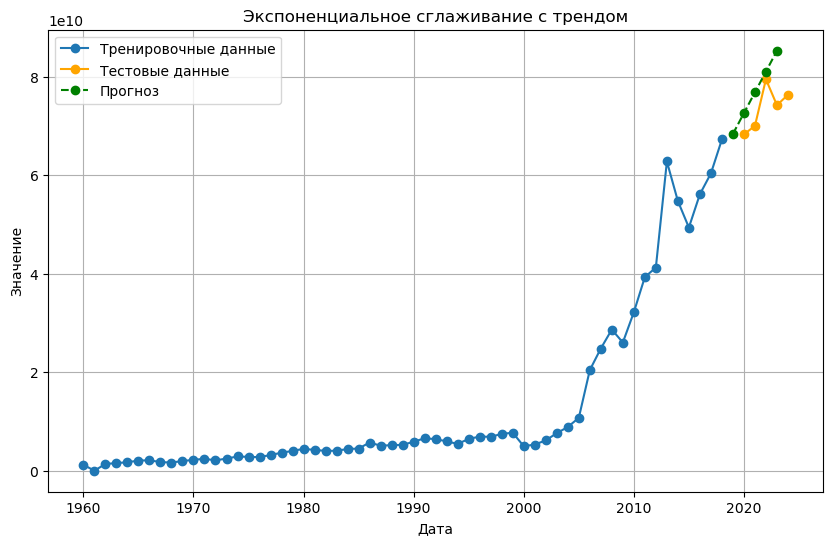

In [ ]:
test_new = df_new.iloc[-5:]
forecast_exp_new = model.forecast(steps=5)

plt.figure(figsize=(10, 6))
plt.plot(train, label='Тренировочные данные', marker='o')
plt.plot(test_new, label='Тестовые данные', marker='o', color='orange')
plt.plot(forecast_exp_new, label='Прогноз', linestyle='--', marker='o', color='green')

plt.title("Экспоненциальное сглаживание с трендом")
plt.xlabel("Дата")
plt.ylabel("Значение")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
print(f' RMSE {root_mean_squared_error(test_new, forecast_exp_new):.0f}')
print(f' MAPE - {mean_absolute_percentage_error(test_new, forecast_exp_new)*100:.3f}%')

 RMSE 5304844687
 MAPE - 5.621%


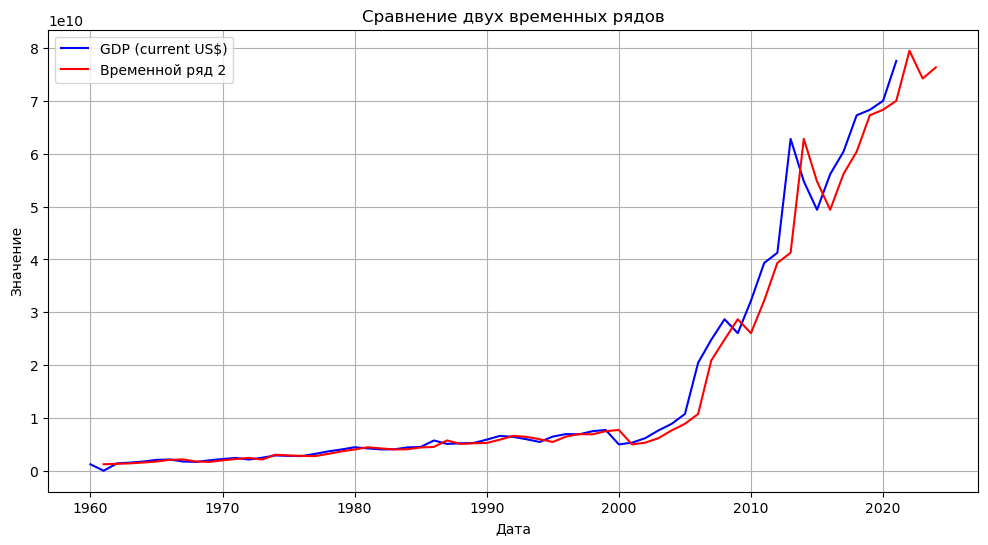

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['GDP (current US$)'], label='GDP (current US$)', color='blue')  # Замените 'Value' на название столбца
plt.plot(df_new.index, df_new['GDP'], label='Временной ряд 2', color='red')  # Замените 'Value' на название столбца

plt.title('Сравнение двух временных рядов')
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.legend()
plt.grid(True)
plt.show()

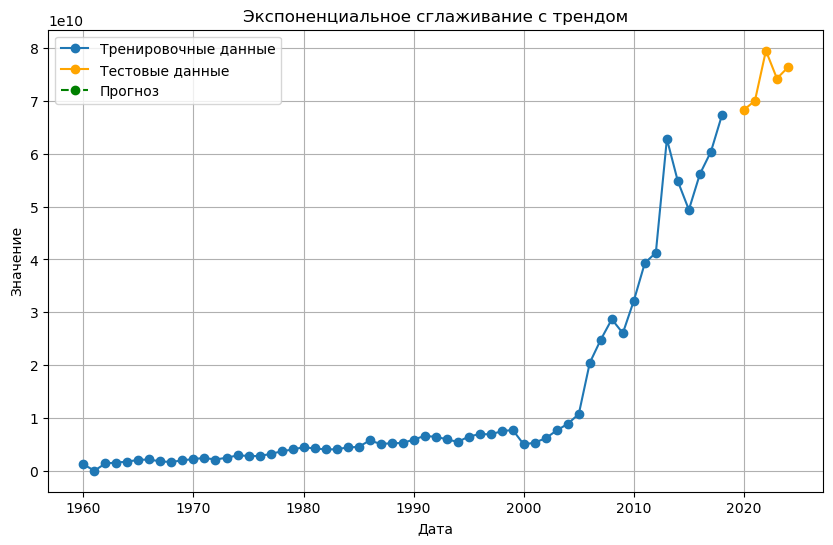

In [ ]:

plt.figure(figsize=(10, 6))
plt.plot(train, label='Тренировочные данные', marker='o')
plt.plot(test_new, label='Тестовые данные', marker='o', color='orange')
plt.plot(forecast_auto_m1_df_new, label='Прогноз', linestyle='--', marker='o', color='green')

plt.title("Экспоненциальное сглаживание с трендом")
plt.xlabel("Дата")
plt.ylabel("Значение")
plt.legend()
plt.grid(True)
plt.show()

________

#  <span style="color:red; font-size:24px;">●</span> Catboost

____

In [68]:
from catboost import CatBoostRegressor

<span style="font-size:19px;"> Необходимо сделать фичи в виде временных лагов. Возьму из авторегрессии 

In [55]:
df_new = pd.read_csv('C:\\Users\\m9032\\jupyter\\data\\ghana-gdp-gross-domestic-product.csv', skiprows=8, parse_dates=['Date'], index_col=['Date'], usecols=[' GDP (Billions of US $)', 'Date'])

# Домножим, чтобы был одникавый маштаб 
df_new['GDP'] = df_new[' GDP (Billions of US $)'] * 10e+08 
df_new =df_new.drop(' GDP (Billions of US $)', axis=1)

In [49]:
# создаем лаги операясь на acf
df_new['lag_1'] = df_new['GDP'].shift(1)
df_new['lag_2'] = df_new['GDP'].shift(2)
df_new['lag_4'] = df_new['GDP'].shift(4)
df_new['lag_5'] = df_new['GDP'].shift(5)

# Удаление NA после создания лагов
df_new.dropna(inplace=True)

In [50]:
df_new.head()

,GDP,lag_1,lag_2,lag_4,lag_5
Date,,,,,
1965-12-31,2.064789e+09,1.740845e+09,1.549296e+09,1.309859e+09,1.223944e+09
1966-12-31,2.138028e+09,2.064789e+09,1.740845e+09,1.390141e+09,1.309859e+09
1967-12-31,1.748837e+09,2.138028e+09,2.064789e+09,1.549296e+09,1.390141e+09
1968-12-31,1.666667e+09,1.748837e+09,2.138028e+09,1.740845e+09,1.549296e+09
1969-12-31,1.961765e+09,1.666667e+09,1.748837e+09,2.064789e+09,1.740845e+09


In [51]:
# Разделим выборки
train = df_new[df_new.index < "2020-01-01"]
test = df_new[df_new.index >= "2020-01-01"]

X_train = train.drop(columns=['GDP'])
y_train = train['GDP']
X_test = test.drop(columns=['GDP'])
y_test = test['GDP']

In [52]:
# Модель CatBoost
cat_model = CatBoostRegressor(
    iterations=1000,
    depth=7,
    learning_rate=0.05,
    loss_function='RMSE'
)
cat_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=2500,
    early_stopping_rounds=250
)

0:	learn: 18892279020.6705627	test: 58641896095.0329437	best: 58641896095.0329437 (0)	total: 162ms	remaining: 2m 42s
Stopped by overfitting detector  (250 iterations wait)

bestTest = 1.061433282e+10
bestIteration = 367

Shrink model to first 368 iterations.


In [53]:
y_pred = cat_model.predict(X_test)

In [54]:
print(f' RMSE для второй модели - {root_mean_squared_error(y_test, y_pred):.0f}')
print(f' MAPE для второй модели - {mean_absolute_percentage_error(y_test, y_pred)*100:.3f}%')

 RMSE для второй модели - 10614332371
 MAPE для второй модели - 13.193%


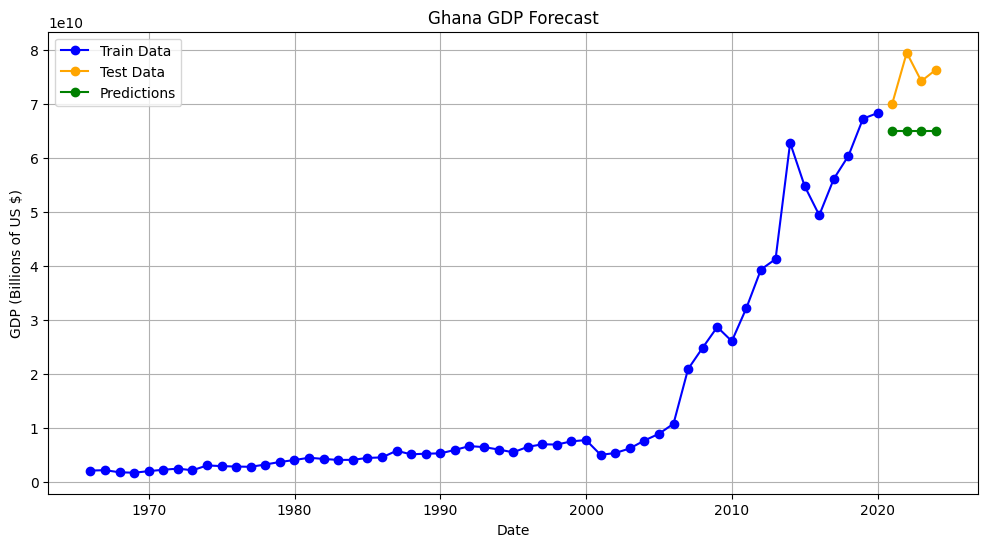

In [247]:
# Создадим временную метку для тестовых предсказаний
y_pred_series = pd.Series(y_pred, index=X_test.index)


plt.figure(figsize=(12, 6))
plt.plot(y_train, label='Train Data', color='blue', linestyle='-', marker='o')  # Тренировочные данные
plt.plot(y_test, label='Test Data', color='orange', linestyle='-', marker='o')  # Тестовые данные
plt.plot(y_pred_series, label='Predictions', color='green', linestyle='-', marker='o')  # Предсказания

plt.title('Ghana GDP Forecast')
plt.xlabel('Date')
plt.ylabel('GDP (Billions of US $)')
plt.legend()
plt.grid(True)
plt.show()

<span style="font-size:19px;"> Хоть метрика неплохая, но отсутствует предсказательная способность

___

<span style="font-size:19px;"> Возможно слишком маленькая выборка, сделаю интерполяцию

In [294]:
df_new = pd.read_csv('data/ghana-gdp-gross-domestic-product.csv', skiprows=8, parse_dates=['Date'], index_col=['Date'], usecols=[' GDP (Billions of US $)', 'Date'])
# Домножим, чтобы был одникавый маштаб 
df_new['GDP'] = df_new[' GDP (Billions of US $)'] * 10e+08 
df_new =df_new.drop(' GDP (Billions of US $)', axis=1)

In [56]:
# Увеличение частоты до ежемесячной
df_monthly = df_new.resample('ME').asfreq()
# Полиномиальная интерполяция (2-й степени)
df_monthly['GDP_polynomial'] = df_monthly['GDP'].interpolate(method='polynomial', order=2)

In [57]:
df_monthly

,GDP,GDP_polynomial
Date,,
1960-12-31,1.223944e+09,1.223944e+09
1961-01-31,NaN,1.232108e+09
1961-02-28,NaN,1.239343e+09
1961-03-31,NaN,1.247201e+09
1961-04-30,NaN,1.254651e+09
...,...,...
2023-08-31,NaN,7.434732e+10
2023-09-30,NaN,7.472202e+10
2023-10-31,NaN,7.519333e+10


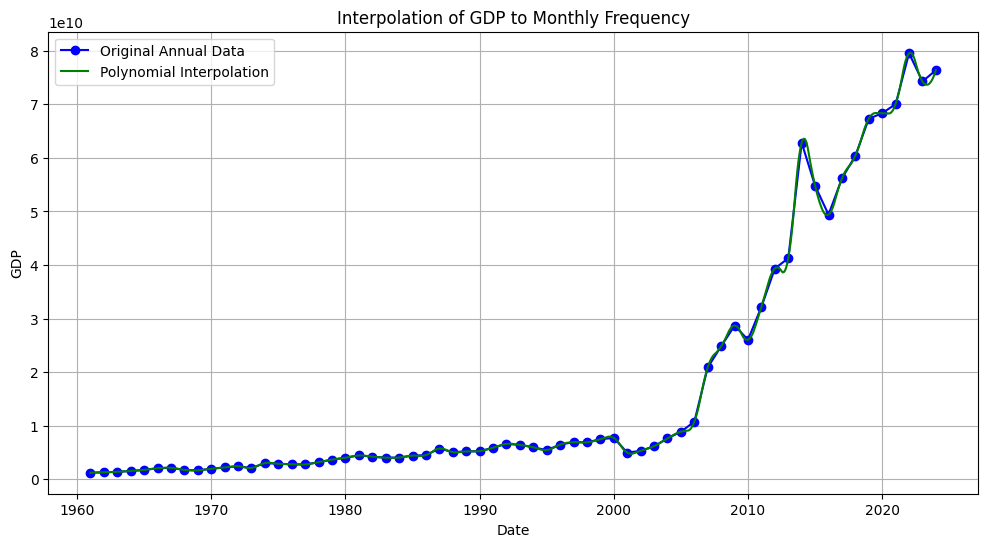

In [58]:
plt.figure(figsize=(12, 6))
plt.plot(df_new.index, df_new['GDP'], 'o-', label='Original Annual Data', color='blue')
plt.plot(df_monthly.index, df_monthly['GDP_polynomial'], '-', label='Polynomial Interpolation', color='green')
plt.title('Interpolation of GDP to Monthly Frequency')
plt.xlabel('Date')
plt.ylabel('GDP')
plt.legend()
plt.grid(True)
plt.show()

<span style="font-size:19px;"> Данные достаточно похожи

In [59]:
df_monthly

,GDP,GDP_polynomial
Date,,
1960-12-31,1.223944e+09,1.223944e+09
1961-01-31,NaN,1.232108e+09
1961-02-28,NaN,1.239343e+09
1961-03-31,NaN,1.247201e+09
1961-04-30,NaN,1.254651e+09
...,...,...
2023-08-31,NaN,7.434732e+10
2023-09-30,NaN,7.472202e+10
2023-10-31,NaN,7.519333e+10


In [60]:
# Тк есть GDP_polynomial, удалим GDP
df_monthly = df_monthly.drop('GDP', axis=1)

<span style="font-size:19px;"> Теперь найдем автокорреляцию для месячных данных, для создания лагов 

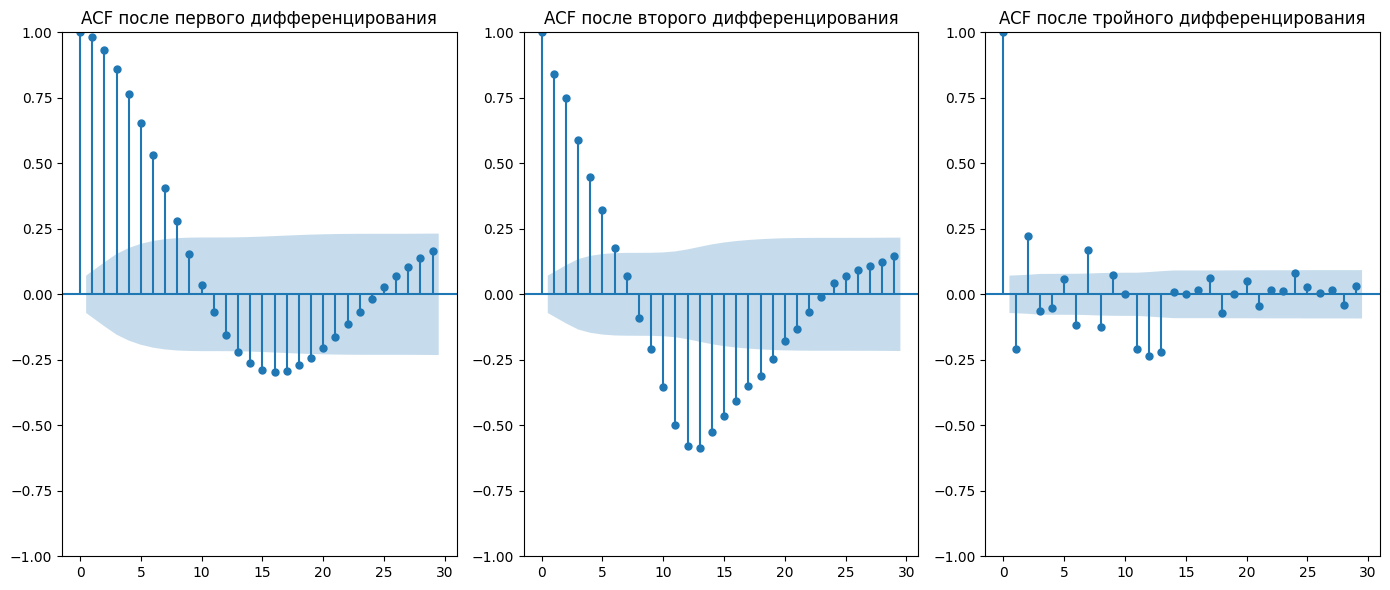

In [61]:
# Приведем данные к стационарному виду
data3 = df_monthly.diff().diff().diff().dropna()

# Приведем данные к стационарному виду 
data1 = df_monthly.diff().dropna()
data2 = df_monthly.diff().diff().dropna()

# Визуализация ACF-графиков для разных степеней стационарности
fig, axs = plt.subplots(1, 3, figsize=(14, 6))


plot_acf(data1, ax=axs[0])
axs[0].set_title("ACF после первого дифференцирования")


plot_acf(data2, ax=axs[1])
axs[1].set_title("ACF после второго дифференцирования")


plot_acf(data3, ax=axs[2])
axs[2].set_title("ACF после тройного дифференцирования")

plt.tight_layout()
plt.show()

<span style="font-size:19px;"> Видно, что стационарность есть только на третьем графике, но нужно больше лагов (тк теперь месячная частота)

<span style="font-size:19px;"> Увеличим количество лагов, подкрасим пики, которые больше порога, и выведем их индексы

In [62]:
from statsmodels.tsa.stattools import acf
from scipy.signal import find_peaks

Индексы пиков: [  2   5   7  36  53  58  60  67  84  89  96 120 127 132 180]


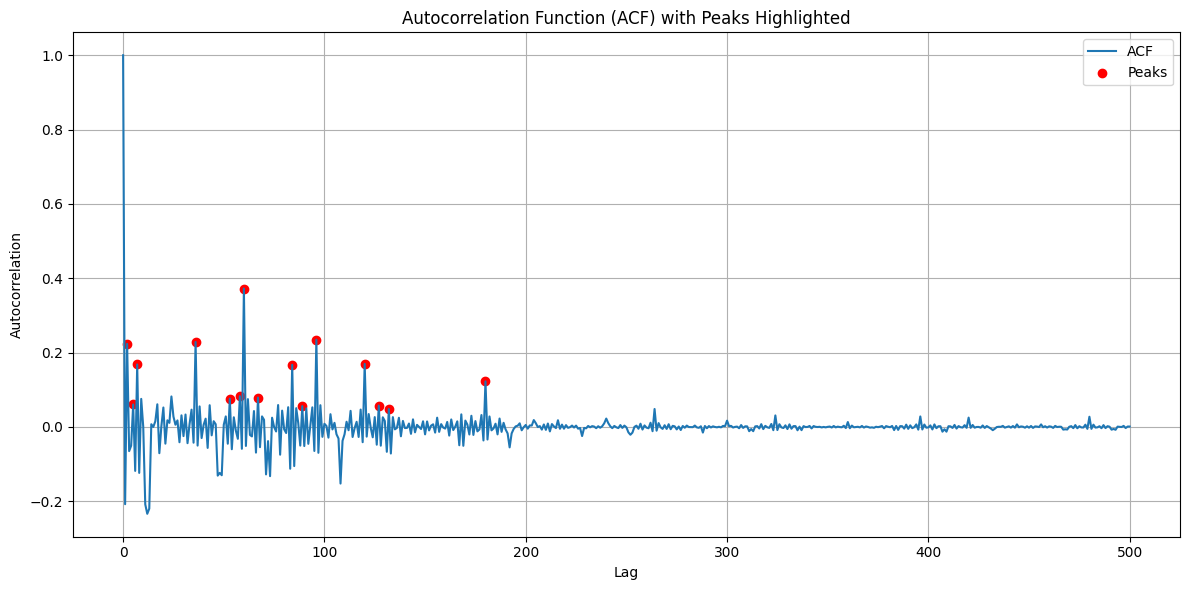

In [63]:
# Вычисляем автокорреляцию для всех лагов
acf_values = acf(data3, nlags=500)

# Находим пики автокорреляции
peaks, _ = find_peaks(acf_values, threshold=0.1)  # Только пики > 0.1

# Печатаем индексы пиков
print("Индексы пиков:", peaks)

# Построение графика с пиками
plt.figure(figsize=(12, 6))

plt.plot(acf_values, label='ACF')
plt.scatter(peaks, acf_values[peaks], color='red', label='Peaks')  # Помечаем пики точками

plt.title('Autocorrelation Function (ACF) with Peaks Highlighted')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

<span style="font-size:19px;"> Нижние тоже нужны

Индексы положительных пиков: [  2   7  36  60  84  96 120 180]
Индексы отрицательных пиков: [  1   6   8  12  47  49  71  73  83  85 108]


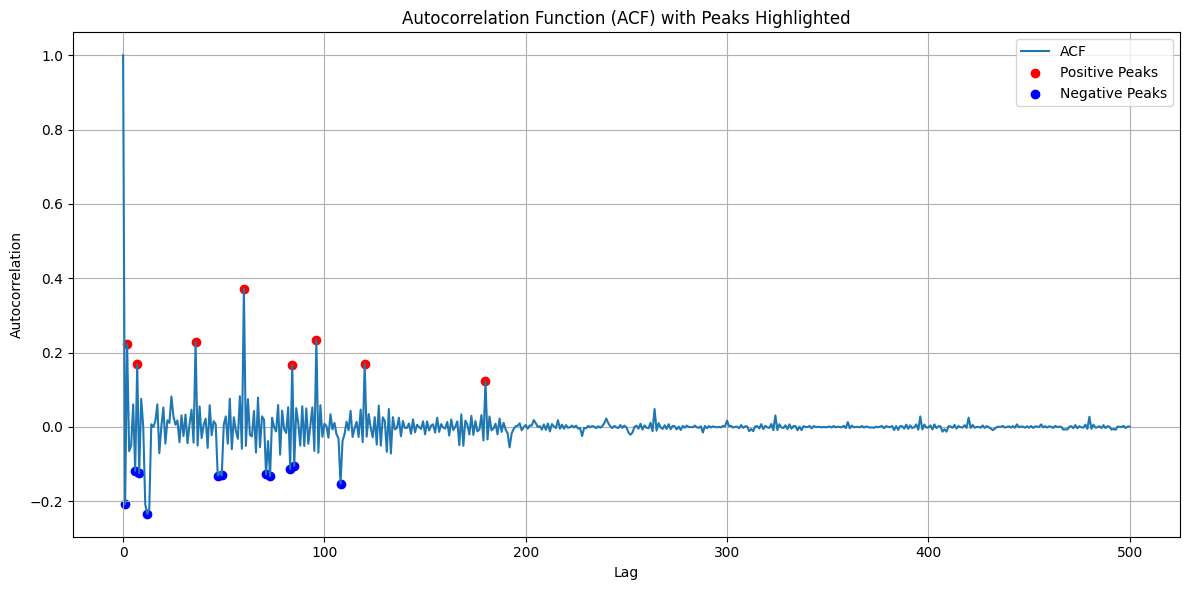

In [64]:
# Положительные пики с порогом > 0.1
positive_peaks, _ = find_peaks(acf_values, height=0.1)

# Отрицательные пики с порогом < -0.1 (находим пики в -acf_values)
negative_peaks, _ = find_peaks(-acf_values, height=0.1)

# Печатаем индексы положительных и отрицательных пиков
print("Индексы положительных пиков:", positive_peaks)
print("Индексы отрицательных пиков:", negative_peaks)


plt.figure(figsize=(12, 6))

plt.plot(acf_values, label='ACF')
plt.scatter(positive_peaks, acf_values[positive_peaks], color='red', label='Positive Peaks')  # Положительные пики
plt.scatter(negative_peaks, acf_values[negative_peaks], color='blue', label='Negative Peaks')  # Отрицательные пики

plt.title('Autocorrelation Function (ACF) with Peaks Highlighted')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

<span style="font-size:16px;"> Возможно я подгоняю данные под интерполяцию, но как этого избежать, не знаю, только если рандомно обрезать лаги, но, кажется, не самый лучший вариант :)

In [65]:
# создаем лаги операясь на acf
df_monthly['lag_1'] = df_monthly['GDP_polynomial'].shift(1)
df_monthly['lag_2'] = df_monthly['GDP_polynomial'].shift(2)
df_monthly['lag_6'] = df_monthly['GDP_polynomial'].shift(6)
df_monthly['lag_7'] = df_monthly['GDP_polynomial'].shift(7)
df_monthly['lag_8'] = df_monthly['GDP_polynomial'].shift(8)
df_monthly['lag_12'] = df_monthly['GDP_polynomial'].shift(12)
df_monthly['lag_36'] = df_monthly['GDP_polynomial'].shift(36)
df_monthly['lag_47'] = df_monthly['GDP_polynomial'].shift(47)
df_monthly['lag_49'] = df_monthly['GDP_polynomial'].shift(49)
df_monthly['lag_60'] = df_monthly['GDP_polynomial'].shift(60)
df_monthly['lag_71'] = df_monthly['GDP_polynomial'].shift(71)
df_monthly['lag_73'] = df_monthly['GDP_polynomial'].shift(73)
df_monthly['lag_83'] = df_monthly['GDP_polynomial'].shift(83)
df_monthly['lag_84'] = df_monthly['GDP_polynomial'].shift(84)
df_monthly['lag_85'] = df_monthly['GDP_polynomial'].shift(85)
df_monthly['lag_96'] = df_monthly['GDP_polynomial'].shift(96)
df_monthly['lag_108'] = df_monthly['GDP_polynomial'].shift(108)
df_monthly['lag_120'] = df_monthly['GDP_polynomial'].shift(120)
df_monthly['lag_180'] = df_monthly['GDP_polynomial'].shift(180)

# Удаление NA после создания лагов
df_monthly.dropna(inplace=True)

In [66]:
df_monthly

,GDP_polynomial,lag_1,lag_2,lag_6,lag_7,lag_8,lag_12,lag_36,lag_47,lag_49,lag_60,lag_71,lag_73,lag_83,lag_84,lag_85,lag_96,lag_108,lag_120,lag_180
Date,,,,,,,,,,,,,,,,,,,,
1975-12-31,2.810106e+09,2.816643e+09,2.822171e+09,2.836629e+09,2.839951e+09,2.845995e+09,2.894410e+09,2.116541e+09,2.408934e+09,2.437726e+09,2.214706e+09,1.986086e+09,1.936310e+09,1.680557e+09,1.666667e+09,1.656055e+09,1.748837e+09,2.138028e+09,2.064789e+09,1.223944e+09
1976-01-31,2.802731e+09,2.810106e+09,2.816643e+09,2.834226e+09,2.836629e+09,2.839951e+09,2.878093e+09,2.153029e+09,2.384882e+09,2.427184e+09,2.239852e+09,2.007081e+09,1.961765e+09,1.695923e+09,1.680557e+09,1.666667e+09,1.724551e+09,2.118541e+09,2.085318e+09,1.232108e+09
1976-02-29,2.795072e+09,2.802731e+09,2.810106e+09,2.830989e+09,2.834226e+09,2.836629e+09,2.865636e+09,2.198924e+09,2.351710e+09,2.408934e+09,2.263497e+09,2.029246e+09,1.986086e+09,1.716055e+09,1.695923e+09,1.680557e+09,1.704710e+09,2.096934e+09,2.102225e+09,1.239343e+09
1976-03-31,2.786074e+09,2.795072e+09,2.802731e+09,2.827058e+09,2.830989e+09,2.834226e+09,2.854370e+09,2.264062e+09,2.312268e+09,2.384882e+09,2.290707e+09,2.049619e+09,2.007081e+09,1.738660e+09,1.716055e+09,1.695923e+09,1.686578e+09,2.068577e+09,2.119133e+09,1.247201e+09
1976-04-30,2.776568e+09,2.786074e+09,2.795072e+09,2.822171e+09,2.827058e+09,2.830989e+09,2.845995e+09,2.341432e+09,2.263927e+09,2.351710e+09,2.318072e+09,2.069555e+09,2.029246e+09,1.765244e+09,1.738660e+09,1.716055e+09,1.672057e+09,2.036698e+09,2.133683e+09,1.254651e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-31,7.434732e+10,7.404426e+10,7.382669e+10,7.380082e+10,7.398172e+10,7.426336e+10,7.620213e+10,6.847353e+10,6.835718e+10,6.836823e+10,6.535027e+10,5.917010e+10,5.856694e+10,5.440637e+10,5.373676e+10,5.299515e+10,4.973720e+10,5.882539e+10,5.737200e+10,2.804349e+10
2023-09-30,7.472202e+10,7.434732e+10,7.404426e+10,7.368190e+10,7.380082e+10,7.398172e+10,7.560261e+10,6.871067e+10,6.835105e+10,6.836278e+10,6.592087e+10,5.954270e+10,5.885192e+10,5.504861e+10,5.440637e+10,5.373676e+10,4.949158e+10,5.774098e+10,5.919901e+10,2.831848e+10
2023-10-31,7.519333e+10,7.472202e+10,7.434732e+10,7.364823e+10,7.368190e+10,7.380082e+10,7.506722e+10,6.905767e+10,6.834478e+10,6.835718e+10,6.644785e+10,5.994569e+10,5.917010e+10,5.562206e+10,5.504861e+10,5.440637e+10,4.935026e+10,5.668239e+10,6.075381e+10,2.852136e+10


---

<span style="font-size:19px;"> Теперь построим модель

In [70]:
# Разделим выборки
train_inter = df_monthly[df_monthly.index < "2020-01-01"]
test_inter = df_monthly[df_monthly.index >= "2020-01-01"]

X_train_inter = train_inter.drop(columns=['GDP_polynomial'])
y_train_inter = train_inter['GDP_polynomial']
X_test_inter = test_inter.drop(columns=['GDP_polynomial'])
y_test_inter = test_inter['GDP_polynomial']


In [73]:
# Модель CatBoost
cat_model_inter = CatBoostRegressor(
    iterations=1000,
    depth=7,
    learning_rate=0.05,
    loss_function='RMSE'
)
cat_model_inter.fit(
    X_train_inter, y_train_inter,
    eval_set=[(X_test_inter, y_test_inter)],
    verbose=250,
    early_stopping_rounds=100
)
y_pred_inter = cat_model_inter.predict(X_test_inter)
print(f' RMSE для второй модели - {root_mean_squared_error(y_test_inter, y_pred_inter):.0f}')
print(f' MAPE для второй модели - {mean_absolute_percentage_error(y_test_inter, y_pred_inter)*100:.3f}%')

0:	learn: 19119181637.2216492	test: 54583539867.8149490	best: 54583539867.8149490 (0)	total: 8.64ms	remaining: 8.63s
250:	learn: 168691088.5641533	test: 7143311219.2288733	best: 7143311219.2288733 (250)	total: 1.73s	remaining: 5.17s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 7134289413
bestIteration = 290

Shrink model to first 291 iterations.
 RMSE для второй модели - 7134288965
 MAPE для второй модели - 7.896%


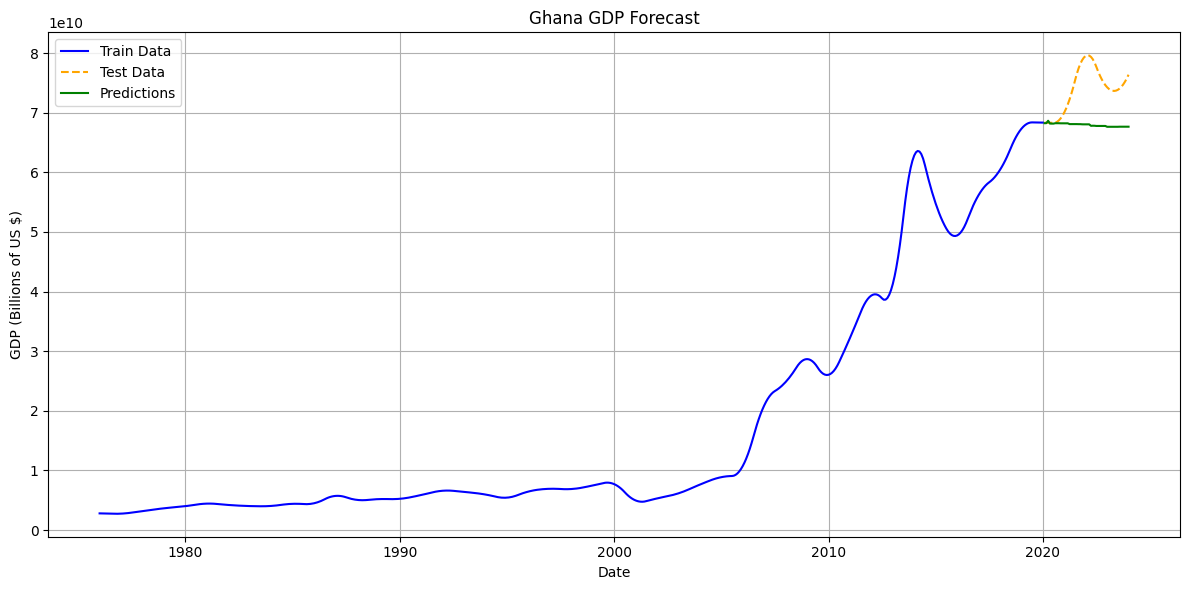

In [74]:
# Создание временного ряда для предсказаний
y_pred_series = pd.Series(y_pred_inter, index=X_test_inter.index)

plt.figure(figsize=(12, 6))

# Тренировочные данные
plt.plot(y_train_inter.index, y_train_inter, label='Train Data', color='blue')

# Тестовые данные
plt.plot(y_test_inter.index, y_test_inter, label='Test Data', color='orange', linestyle='--')

# Предсказания
plt.plot(y_pred_series.index, y_pred_series, label='Predictions', color='green')


plt.title('Ghana GDP Forecast')
plt.xlabel('Date')
plt.ylabel('GDP (Billions of US $)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

<span style="font-size:19px;"> Метрика стала значительно лучше, но предсказательной силы все еще нет 